In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.xception import Xception
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/xception")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

7


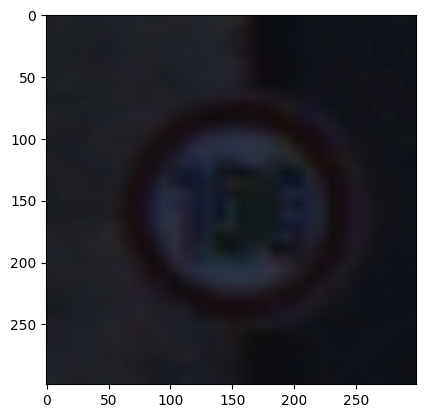

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = Xception(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
Xception                                                --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 896
│    │    └─ReLU: 3-2                                   --
│    └─Conv2dNormActivation: 2-2                        --
│    │    └─Conv2d: 3-3                                 18,496
│    │    └─ReLU: 3-4                                   --
│    └─ResBlock: 2-3                                    --
│    │    └─Sequential: 3-5                             27,200
│    │    └─Sequential: 3-6                             8,448
│    └─ResBlock: 2-4                                    --
│    │    └─Sequential: 3-7                             103,552
│    │    └─Sequential: 3-8                             33,280
│    └─ResBlock: 2-5                                    --
│    │    └─Sequential: 3-9   

# training

In [13]:
epochs = 10
acc_iters = 32 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epochs, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1665/1665 [14:03<00:00,  1.97it/s]


epoch 1 : 0.03417240710496936


100%|██████████| 1665/1665 [05:15<00:00,  5.27it/s]


epoch 2 : 0.003500764016862595


100%|██████████| 1665/1665 [04:43<00:00,  5.88it/s]


epoch 3 : 0.0022131438772730718


100%|██████████| 1665/1665 [04:42<00:00,  5.90it/s]


epoch 4 : 0.0016633528589485725


100%|██████████| 1665/1665 [04:41<00:00,  5.91it/s]


epoch 5 : 0.0013041376657080643


100%|██████████| 1665/1665 [04:42<00:00,  5.89it/s]


epoch 6 : 0.0011548139164667284


100%|██████████| 1665/1665 [04:52<00:00,  5.69it/s]


epoch 7 : 0.0011379653676467309


100%|██████████| 1665/1665 [04:58<00:00,  5.58it/s]


epoch 8 : 0.0012398316610423544


100%|██████████| 1665/1665 [05:12<00:00,  5.33it/s]


epoch 9 : 0.0006904900129039543


100%|██████████| 1665/1665 [05:01<00:00,  5.53it/s]

epoch 10 : 0.0007808146822799517


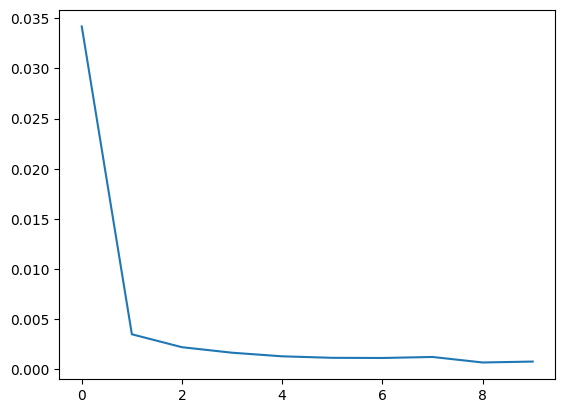

In [17]:
plt.plot(training_loss)

# inference

In [15]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [16]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [17]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [18]:
evaluator = ClassificationEvaluator(num_class, device)

In [19]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 790/790 [03:27<00:00,  3.80it/s]

[[ 51   0   0 ...   0   0   0]
 [  0 710   0 ...   0   0   0]
 [  0   2 744 ...   0   0   0]
 ...
 [  0   0   0 ...  74   0   0]
 [  0   0   0 ...   0  57   2]
 [  0   0   0 ...   1  19  69]]


In [20]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.85
1         : 0.9861111111111112
2         : 0.992
3         : 0.9755555555555555
4         : 0.9878787878787879
5         : 0.9920634920634921
6         : 0.8933333333333333
7         : 0.9955555555555555
8         : 0.92
9         : 1.0
10        : 1.0
11        : 1.0
12        : 0.981159420289855
13        : 0.9944444444444445
14        : 1.0
15        : 1.0
16        : 1.0
17        : 0.9388888888888889
18        : 0.9871794871794872
19        : 0.03333333333333333
20        : 0.8444444444444444
21        : 0.9777777777777777
22        : 0.825
23        : 0.9933333333333333
24        : 0.9888888888888889
25        : 0.975
26        : 0.9111111111111111
27        : 0.9833333333333333
28        : 1.0
29        : 0.9666666666666667
30        : 0.9133333333333333
31        : 1.0
32        : 1.0
33        : 0.9523809523809523
34        : 0.5
35        : 0.9846153846153847
36        : 0.8333333333333334
37        : 0.95
38        : 0.9637681159420289
39        : 0.28888888

In [21]:
per_class_acc.mean()

0.905075996804005

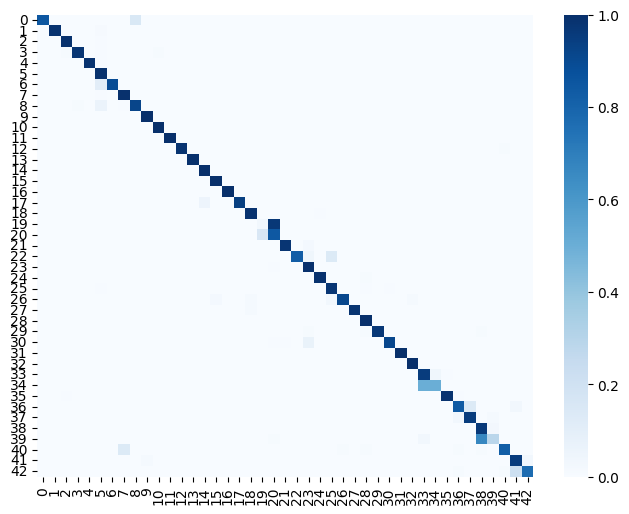

In [22]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [13]:
model_path = artifact_path / f'xception.pth'

In [24]:
torch.save(model.state_dict(), model_path)

In [25]:
get_file_size(model_path)

'36.93MiB'

In [14]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>